<a href="https://colab.research.google.com/github/Zero-Asif/IML/blob/GNN/GNN(small_dataset_Cora).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cpu.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=545106 sha256=1f410bff7e4bb0bd4aeb028ac197942890cd72bf52aaf7b07e54105a888e822f
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1122943 sha256=83c55117da57ed78b49fac0d560d6e991439095

Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Using device: cpu
Epoch: 000, Loss: 16.8271, Test Acc: 0.6970
Epoch: 002, Loss: 9.2531, Test Acc: 0.8330
Epoch: 004, Loss: 4.7129, Test Acc: 0.8350
Epoch: 006, Loss: 2.8072, Test Acc: 0.8640
Epoch: 008, Loss: 1.5946, Test Acc: 0.8800
Epoch: 010, Loss: 1.2931, Test Acc: 0.8910
Epoch: 012, Loss: 0.9698, Test Acc: 0.8640
Epoch: 014, Loss: 0.7718, Test Acc: 0.8560
Epoch: 016, Loss: 0.6794, Test Acc: 0.8650
Epoch: 018, Loss: 0.5712, Test Acc: 0.8690
Final Test Accuracy: 0.8670


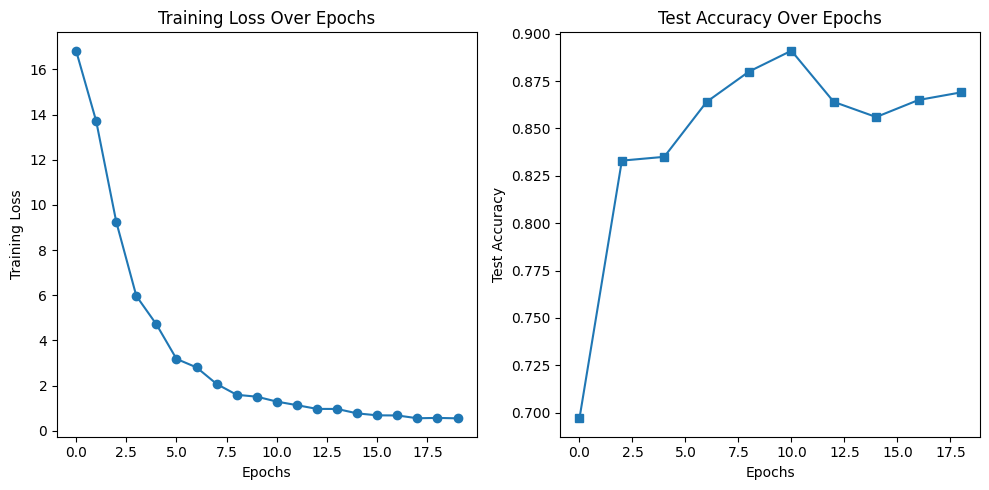

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader

# Load the Cora dataset (small and fast)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move dataset to GPU
data = data.to(device)

# Initialize the model, optimizer, and loss function
model = GraphSAGE(dataset.num_features, 128, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Create NeighborLoader for training with optimized settings
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],  # Smaller neighbor samples for speed
    batch_size=128,  # Smaller batch size for quick training
    shuffle=True,
    input_nodes=data.train_mask
)

# Lists to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_nodes
    return total_loss / len(train_loader.dataset)

# Evaluation function
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=-1)
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    return correct / data.test_mask.sum().item()

# Training and testing loop
num_epochs = 20
for epoch in range(num_epochs):
    loss = train()
    train_losses.append(loss)

    if epoch % 2 == 0:
        acc = test()
        test_accuracies.append(acc)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

# Final test accuracy
acc = test()
print(f'Final Test Accuracy: {acc:.4f}')

# Plot training loss and test accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(range(0, num_epochs, 2), test_accuracies, marker='s', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Over Epochs")

plt.tight_layout()
plt.show()
